In [8]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [1]:
# Exercice 6 : Étiquetage des catégories construites
# M2 MIASHS : projet Network Analysis for Information Retrieval

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import os
import warnings
from collections import Counter, defaultdict
warnings.filterwarnings('ignore')

# Pour la visualisation
from wordcloud import WordCloud
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Pour le traitement de texte
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA, TruncatedSVD

# Pour les collocations
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures, TrigramCollocationFinder, TrigramAssocMeasures

# Téléchargement des ressources NLTK nécessaires
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Configuration pour un meilleur affichage
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [2]:
#===========================================================================================
# 1. Chargement et préparation des données
#===========================================================================================

def load_processed_data(file_path):
    """
    Charge les données traitées lors des exercices précédents.

    Args:
        file_path (str): Chemin du fichier pickle contenant le DataFrame

    Returns:
        pandas.DataFrame: DataFrame contenant les articles
    """
    try:
        df = pd.read_pickle(file_path)
        print(f"Données chargées avec succès. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Erreur lors du chargement des données: {e}")
        return None

def identify_cluster_column(df):
    """
    Identifie la colonne contenant les étiquettes de cluster.

    Args:
        df (pandas.DataFrame): DataFrame contenant les articles

    Returns:
        str: Nom de la colonne de cluster
    """
    cluster_columns = [col for col in df.columns if 'cluster' in col.lower()]

    if not cluster_columns:
        print("Aucune colonne de cluster trouvée.")
        return None

    # S'il y a plusieurs colonnes de cluster, choisir celle qui semble la plus pertinente
    if len(cluster_columns) > 1:
        print(f"Plusieurs colonnes de cluster trouvées: {cluster_columns}")
        print(f"Utilisation de la première: {cluster_columns[0]}")

    return cluster_columns[0]

def prepare_texts(df, text_column='combined_text'):
    """
    Prépare les textes pour les analyses.

    Args:
        df (pandas.DataFrame): DataFrame contenant les articles
        text_column (str): Nom de la colonne contenant le texte

    Returns:
        pandas.DataFrame: DataFrame avec texte combiné
    """
    df = df.copy()

    # Vérifier si la colonne 'combined_text' existe déjà
    if text_column not in df.columns:
        # Combiner le titre et le résumé
        df[text_column] = df.apply(
            lambda row: f"{row['title']} {row['abstract'] if pd.notna(row['abstract']) else ''}",
            axis=1
        )

    return df

#===========================================================================================
# 2. Analyse des termes par catégorie
#===========================================================================================

class CategoryLabeler:
    """Classe pour l'étiquetage des catégories (clusters)."""

    def __init__(self, df, cluster_column, text_column='combined_text'):
        """
        Initialise la classe avec le DataFrame d'articles.

        Args:
            df (pandas.DataFrame): DataFrame contenant les articles
            cluster_column (str): Nom de la colonne contenant les étiquettes de cluster
            text_column (str): Nom de la colonne contenant le texte
        """
        self.df = df
        self.cluster_column = cluster_column
        self.text_column = text_column

        # Vérification de l'existence des colonnes
        if cluster_column not in df.columns:
            raise ValueError(f"Colonne de cluster '{cluster_column}' non trouvée dans le DataFrame.")

        if text_column not in df.columns:
            raise ValueError(f"Colonne de texte '{text_column}' non trouvée dans le DataFrame.")

        # Extraction des étiquettes de cluster uniques
        self.clusters = sorted(df[cluster_column].unique())
        # Exclusion du cluster de bruit (-1) s'il existe
        if -1 in self.clusters:
            self.clusters.remove(-1)
            self.clusters = [-1] + self.clusters

        print(f"Nombre de clusters: {len(self.clusters)}")

        # Prétraitement
        self.stop_words = set(stopwords.words('english'))
        # Ajout de stop words spécifiques au domaine scientifique
        scientific_stop_words = [
            'doi', 'fig', 'figure', 'et', 'al', 'paper', 'study', 'research',
            'method', 'results', 'analysis', 'data', 'proposed', 'approach',
            'using', 'based', 'used', 'show', 'shown', 'table', 'section'
        ]
        self.stop_words.update(scientific_stop_words)

        # Stemming
        self.stemmer = PorterStemmer()

        # Structures pour stocker les résultats
        self.cluster_texts = {}
        self.cluster_terms = {}
        self.cluster_collocations = {}
        self.discriminative_terms = {}
        self.central_documents = {}
        self.cluster_labels = {}

        # Préparation des textes par cluster
        self._prepare_cluster_texts()

    def _prepare_cluster_texts(self):
        """
        Prépare les textes pour chaque cluster.
        """
        print("Préparation des textes par cluster...")

        # Pour chaque cluster
        for cluster_id in self.clusters:
            # Sélection des documents de ce cluster
            cluster_docs = self.df[self.df[self.cluster_column] == cluster_id]

            # Stockage des textes
            self.cluster_texts[cluster_id] = cluster_docs[self.text_column].tolist()

    def preprocess_text(self, text):
        """
        Prétraite un texte (minuscules, retrait ponctuation, etc.)

        Args:
            text (str): Texte à prétraiter

        Returns:
            str: Texte prétraité
        """
        if pd.isna(text):
            return ""

        # Conversion en minuscules
        text = text.lower()

        # Suppression des chiffres et de la ponctuation
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', ' ', text)

        # Suppression des espaces multiples
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def tokenize_and_stem(self, text):
        """
        Tokenise et applique le stemming au texte.

        Args:
            text (str): Texte à tokeniser

        Returns:
            list: Liste de stems
        """
        words = word_tokenize(text)
        return [self.stemmer.stem(word) for word in words if word.lower() not in self.stop_words]

    def extract_frequent_terms(self, min_df=2, max_df=0.95, top_n=50):
        """
        Extrait les termes les plus fréquents pour chaque cluster.

        Args:
            min_df (int): Fréquence minimale des termes
            max_df (float): Fréquence maximale des termes
            top_n (int): Nombre de termes à conserver par cluster

        Returns:
            dict: Dictionnaire des termes les plus fréquents par cluster
        """
        print("Extraction des termes les plus fréquents par cluster...")

        # Pour chaque cluster
        for cluster_id in tqdm(self.clusters):
            # Sélection des textes de ce cluster
            texts = self.cluster_texts.get(cluster_id, [])

            if not texts:
                print(f"Aucun texte trouvé pour le cluster {cluster_id}")
                continue

            # Vectorisation
            vectorizer = CountVectorizer(
                preprocessor=self.preprocess_text,
                tokenizer=self.tokenize_and_stem,
                min_df=min_df,
                max_df=max_df
            )

            # Transformation des textes
            try:
                term_matrix = vectorizer.fit_transform(texts)

                # Extraction des termes et de leurs fréquences
                feature_names = vectorizer.get_feature_names_out()
                term_frequencies = np.asarray(term_matrix.sum(axis=0)).flatten()

                # Création d'un dictionnaire {terme: fréquence}
                term_freq_dict = {
                    feature_names[i]: term_frequencies[i]
                    for i in np.argsort(term_frequencies)[::-1][:top_n]
                }

                # Stockage des résultats
                self.cluster_terms[cluster_id] = term_freq_dict

            except Exception as e:
                print(f"Erreur lors de l'extraction des termes pour le cluster {cluster_id}: {e}")

        return self.cluster_terms

    def extract_cluster_collocations(self, n_collocations=30):
        """
        Extrait les collocations (paires de mots) les plus significatives pour chaque cluster.

        Args:
            n_collocations (int): Nombre de collocations à extraire par cluster

        Returns:
            dict: Dictionnaire des collocations par cluster
        """
        print("Extraction des collocations par cluster...")

        # Pour chaque cluster
        for cluster_id in tqdm(self.clusters):
            # Sélection des textes de ce cluster
            texts = self.cluster_texts.get(cluster_id, [])

            if not texts:
                continue

            # Prétraitement des textes
            processed_texts = [self.preprocess_text(text) for text in texts]

            # Tokenisation
            all_tokens = []
            for text in processed_texts:
                words = word_tokenize(text)
                filtered_words = [word.lower() for word in words if word.lower() not in self.stop_words]
                all_tokens.extend(filtered_words)

            # Extraction des collocations (bigrammes)
            finder = BigramCollocationFinder.from_words(all_tokens)

            # Filtrage des collocations rares
            finder.apply_freq_filter(3)

            # Calcul des collocations avec la méthode PMI
            bigram_measures = BigramAssocMeasures()
            collocations = finder.score_ngrams(bigram_measures.pmi)

            # Tri par score et sélection des meilleures
            collocations = sorted(collocations, key=lambda x: x[1], reverse=True)[:n_collocations]

            # Stockage des résultats
            self.cluster_collocations[cluster_id] = collocations

        return self.cluster_collocations

    def calculate_discriminative_terms(self, use_tfidf=True, max_terms=30):
        """
        Calcule les termes les plus discriminants pour chaque cluster.
        Pénalise les termes qui apparaissent dans plusieurs clusters.

        Args:
            use_tfidf (bool): Utiliser TF-IDF pour la pondération
            max_terms (int): Nombre maximum de termes discriminants à conserver

        Returns:
            dict: Dictionnaire des termes discriminants par cluster
        """
        print("Calcul des termes discriminants par cluster...")

        # Création d'un vectoriseur global
        if use_tfidf:
            vectorizer = TfidfVectorizer(
                preprocessor=self.preprocess_text,
                tokenizer=self.tokenize_and_stem,
                min_df=5,
                max_df=0.9
            )
        else:
            vectorizer = CountVectorizer(
                preprocessor=self.preprocess_text,
                tokenizer=self.tokenize_and_stem,
                min_df=5,
                max_df=0.9
            )

        # Vectorisation de tous les textes
        all_texts = self.df[self.text_column].tolist()
        term_matrix = vectorizer.fit_transform(all_texts)
        feature_names = vectorizer.get_feature_names_out()

        # Calcul des scores pour chaque cluster
        for cluster_id in tqdm(self.clusters):
            # Indices des documents de ce cluster
            cluster_indices = self.df[self.df[self.cluster_column] == cluster_id].index.tolist()

            if not cluster_indices:
                continue

            # Sous-matrice pour ce cluster
            cluster_matrix = term_matrix[cluster_indices]

            # Calcul du score de chaque terme
            # Score = fréquence relative dans le cluster / fréquence relative dans les autres clusters
            cluster_term_sum = np.asarray(cluster_matrix.sum(axis=0)).flatten()
            all_term_sum = np.asarray(term_matrix.sum(axis=0)).flatten()
            other_term_sum = all_term_sum - cluster_term_sum

            # Calcul des fréquences relatives
            n_docs_cluster = len(cluster_indices)
            n_docs_total = term_matrix.shape[0]
            n_docs_other = n_docs_total - n_docs_cluster

            # Éviter les divisions par zéro
            cluster_freq = cluster_term_sum / max(1, n_docs_cluster)
            other_freq = other_term_sum / max(1, n_docs_other)

            # Calcul du score de discrimination
            epsilon = 1e-10  # Pour éviter les divisions par zéro
            discrimination_scores = cluster_freq / (other_freq + epsilon)

            # Sélection des termes les plus discriminants
            top_indices = np.argsort(discrimination_scores)[::-1][:max_terms]

            # Création d'un dictionnaire {terme: score}
            discriminative_terms = {
                feature_names[i]: float(discrimination_scores[i])
                for i in top_indices
            }

            # Stockage des résultats
            self.discriminative_terms[cluster_id] = discriminative_terms

        return self.discriminative_terms

    def find_central_documents(self, n_docs=5, use_tfidf=True):
        """
        Trouve les documents les plus centraux (représentatifs) de chaque cluster.

        Args:
            n_docs (int): Nombre de documents centraux à identifier par cluster
            use_tfidf (bool): Utiliser TF-IDF pour la vectorisation

        Returns:
            dict: Dictionnaire des documents centraux par cluster
        """
        print("Recherche des documents centraux par cluster...")

        # Création d'un vectoriseur adapté
        if use_tfidf:
            vectorizer = TfidfVectorizer(
                preprocessor=self.preprocess_text,
                tokenizer=self.tokenize_and_stem,
                min_df=5,
                max_df=0.9
            )
        else:
            vectorizer = CountVectorizer(
                preprocessor=self.preprocess_text,
                tokenizer=self.tokenize_and_stem,
                min_df=5,
                max_df=0.9
            )

        # Pour chaque cluster
        for cluster_id in tqdm(self.clusters):
            # Sélection des documents de ce cluster
            cluster_df = self.df[self.df[self.cluster_column] == cluster_id]

            if len(cluster_df) == 0:
                continue

            # Vectorisation des documents
            texts = cluster_df[self.text_column].tolist()
            try:
                vectors = vectorizer.fit_transform(texts)

                # Calcul du centroïde
                centroid = vectors.mean(axis=0)

                # Conversion en format compatible numpy array
                if hasattr(centroid, 'toarray'):
                    centroid_array = centroid.toarray()
                else:
                    centroid_array = np.asarray(centroid).reshape(1, -1)

                # Calcul des similarités au centroïde
                similarities = cosine_similarity(vectors, centroid_array).flatten()

                # Tri par similarité
                top_indices = similarities.argsort()[::-1][:n_docs]

                # Récupération des documents centraux
                central_docs = []
                for idx in top_indices:
                    doc = cluster_df.iloc[idx]
                    central_docs.append({
                        'index': cluster_df.index[idx],
                        'title': doc['title'],
                        'abstract': doc.get('abstract', ''),
                        'similarity': similarities[idx]
                    })

                # Stockage des résultats
                self.central_documents[cluster_id] = central_docs

            except Exception as e:
                print(f"Erreur lors de la recherche des documents centraux pour le cluster {cluster_id}: {e}")

        return self.central_documents

    def create_cluster_labels(self, n_terms=5, use_discriminative=True):
        """
        Crée des étiquettes pour chaque cluster à partir des termes discriminants.

        Args:
            n_terms (int): Nombre de termes à inclure dans l'étiquette
            use_discriminative (bool): Utiliser les termes discriminants ou fréquents

        Returns:
            dict: Dictionnaire des étiquettes par cluster
        """
        print("Création des étiquettes de cluster...")

        for cluster_id in self.clusters:
            # Sélection des termes appropriés
            if use_discriminative and cluster_id in self.discriminative_terms:
                terms = self.discriminative_terms[cluster_id]
            elif cluster_id in self.cluster_terms:
                terms = self.cluster_terms[cluster_id]
            else:
                print(f"Aucun terme trouvé pour le cluster {cluster_id}")
                continue

            # Sélection des n meilleurs termes
            top_terms = list(terms.items())[:n_terms]

            # Création de l'étiquette
            label = f"Cluster {cluster_id}: " + ", ".join([term for term, _ in top_terms])

            # Stockage de l'étiquette
            self.cluster_labels[cluster_id] = label

        return self.cluster_labels

    def generate_cluster_summary(self, cluster_id, n_terms=10, n_collocations=5, n_docs=3):
        """
        Génère un résumé textuel d'un cluster.

        Args:
            cluster_id: Identifiant du cluster
            n_terms (int): Nombre de termes à inclure
            n_collocations (int): Nombre de collocations à inclure
            n_docs (int): Nombre de documents centraux à inclure

        Returns:
            str: Résumé du cluster
        """
        summary = [f"# Résumé du Cluster {cluster_id}"]

        # Nombre de documents
        n_docs_in_cluster = len(self.df[self.df[self.cluster_column] == cluster_id])
        summary.append(f"\n## Informations générales")
        summary.append(f"- Nombre de documents: {n_docs_in_cluster}")

        # Termes fréquents
        if cluster_id in self.cluster_terms:
            summary.append(f"\n## Termes les plus fréquents")
            terms = list(self.cluster_terms[cluster_id].items())[:n_terms]
            for term, freq in terms:
                summary.append(f"- {term}: {freq}")

        # Termes discriminants
        if cluster_id in self.discriminative_terms:
            summary.append(f"\n## Termes les plus discriminants")
            terms = list(self.discriminative_terms[cluster_id].items())[:n_terms]
            for term, score in terms:
                summary.append(f"- {term}: {score:.4f}")

        # Collocations
        if cluster_id in self.cluster_collocations:
            summary.append(f"\n## Collocations significatives")
            collocations = self.cluster_collocations[cluster_id][:n_collocations]
            for (w1, w2), score in collocations:
                summary.append(f"- '{w1} {w2}': {score:.4f}")

        # Documents centraux
        if cluster_id in self.central_documents:
            summary.append(f"\n## Documents les plus représentatifs")
            docs = self.central_documents[cluster_id][:n_docs]
            for i, doc in enumerate(docs):
                summary.append(f"\n### Document {i+1} (similarité: {doc['similarity']:.4f})")
                summary.append(f"- Titre: {doc['title']}")
                if doc['abstract']:
                    # Tronquer l'abstract s'il est trop long
                    abstract = doc['abstract']
                    if len(abstract) > 300:
                        abstract = abstract[:300] + "..."
                    summary.append(f"- Résumé: {abstract}")

        return "\n".join(summary)

#===========================================================================================
# 3. Visualisations
#===========================================================================================

class CategoryVisualizer:
    """Classe pour visualiser les résultats de l'étiquetage de catégories."""

    def __init__(self, labeler):
        """
        Initialise la classe avec un objet CategoryLabeler.

        Args:
            labeler (CategoryLabeler): Objet contenant les résultats d'étiquetage
        """
        self.labeler = labeler

    def create_term_wordcloud(self, cluster_id, max_words=100, use_discriminative=True, save_path=None):
        """
        Crée un nuage de mots pour les termes d'un cluster.

        Args:
            cluster_id: Identifiant du cluster
            max_words (int): Nombre maximum de mots dans le nuage
            use_discriminative (bool): Utiliser les termes discriminants ou fréquents
            save_path (str): Chemin pour enregistrer l'image

        Returns:
            matplotlib.figure.Figure: Figure Matplotlib
        """
        # Sélection des termes appropriés
        if use_discriminative and cluster_id in self.labeler.discriminative_terms:
            terms = self.labeler.discriminative_terms[cluster_id]
        elif cluster_id in self.labeler.cluster_terms:
            terms = self.labeler.cluster_terms[cluster_id]
        else:
            print(f"Aucun terme trouvé pour le cluster {cluster_id}")
            return None

        # Création du nuage de mots
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap='viridis',
            max_words=max_words,
            collocations=False,
            contour_width=1,
            contour_color='steelblue'
        ).generate_from_frequencies(terms)

        # Affichage
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Nuage de mots pour le Cluster {cluster_id}', fontsize=16)
        plt.tight_layout()

        # Sauvegarde si nécessaire
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)

        plt.show()

        return plt.gcf()

    def plot_discriminative_terms(self, cluster_id, n_terms=20, save_path=None):
        """
        Trace un graphique des termes les plus discriminants d'un cluster.

        Args:
            cluster_id: Identifiant du cluster
            n_terms (int): Nombre de termes à afficher
            save_path (str): Chemin pour enregistrer l'image

        Returns:
            matplotlib.axes._axes.Axes: Objet axes de Matplotlib
        """
        # Vérification de la disponibilité des termes discriminants
        if cluster_id not in self.labeler.discriminative_terms:
            print(f"Aucun terme discriminant trouvé pour le cluster {cluster_id}")
            return None

        # Récupération des termes
        terms = self.labeler.discriminative_terms[cluster_id]

        # Conversion en DataFrame
        df_terms = pd.DataFrame({
            'term': list(terms.keys())[:n_terms],
            'score': list(terms.values())[:n_terms]
        })

        # Création du graphique
        plt.figure(figsize=(12, 10))
        ax = sns.barplot(x='score', y='term', data=df_terms, palette='viridis')
        plt.title(f'Termes les plus discriminants pour le Cluster {cluster_id}', fontsize=16)
        plt.xlabel('Score de discrimination', fontsize=12)
        plt.ylabel('Terme', fontsize=12)
        plt.grid(True, alpha=0.3)

        # Ajout des valeurs sur les barres
        for i, v in enumerate(df_terms['score']):
            ax.text(v + 0.01, i, f"{v:.4f}", color='black', va='center')

        plt.tight_layout()

        # Sauvegarde si nécessaire
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)

        plt.show()

        return ax

    def plot_cluster_sizes(self, save_path=None):
        """
        Trace un graphique de la taille des clusters.

        Args:
            save_path (str): Chemin pour enregistrer l'image

        Returns:
            matplotlib.axes._axes.Axes: Objet axes de Matplotlib
        """
        # Calcul de la taille des clusters
        cluster_sizes = self.labeler.df[self.labeler.cluster_column].value_counts().sort_index()

        # Conversion en DataFrame
        df_sizes = pd.DataFrame({
            'cluster': cluster_sizes.index,
            'size': cluster_sizes.values
        })

        # Création du graphique
        plt.figure(figsize=(12, 8))
        ax = sns.barplot(x='cluster', y='size', data=df_sizes, palette='viridis')
        plt.title('Taille des clusters', fontsize=16)
        plt.xlabel('Cluster', fontsize=12)
        plt.ylabel('Nombre de documents', fontsize=12)
        plt.grid(True, alpha=0.3)

        # Ajout des valeurs sur les barres
        for i, v in enumerate(df_sizes['size']):
            ax.text(i, v + 0.1, str(v), ha='center')

        plt.tight_layout()

        # Sauvegarde si nécessaire
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)

        plt.show()

        return ax

    def plot_collocation_graph(self, cluster_id, n_collocations=15, save_path=None):
        """
        Trace un graphique des collocations les plus significatives d'un cluster.

        Args:
            cluster_id: Identifiant du cluster
            n_collocations (int): Nombre de collocations à afficher
            save_path (str): Chemin pour enregistrer l'image

        Returns:
            matplotlib.axes._axes.Axes: Objet axes de Matplotlib
        """
        # Vérification de la disponibilité des collocations
        if cluster_id not in self.labeler.cluster_collocations:
            print(f"Aucune collocation trouvée pour le cluster {cluster_id}")
            return None

        # Récupération des collocations
        collocations = self.labeler.cluster_collocations[cluster_id][:n_collocations]

        # Conversion en DataFrame
        df_collocations = pd.DataFrame([
            {'collocation': ' + '.join(colloc[0]), 'score': colloc[1]}
            for colloc in collocations
        ])

        # Création du graphique
        plt.figure(figsize=(12, 10))
        ax = sns.barplot(x='score', y='collocation', data=df_collocations, palette='viridis')
        plt.title(f'Collocations les plus significatives pour le Cluster {cluster_id}', fontsize=16)
        plt.xlabel('Score PMI', fontsize=12)
        plt.ylabel('Collocation', fontsize=12)
        plt.grid(True, alpha=0.3)

        # Ajout des valeurs sur les barres
        for i, v in enumerate(df_collocations['score']):
            ax.text(v + 0.01, i, f"{v:.4f}", color='black', va='center')

        plt.tight_layout()

        # Sauvegarde si nécessaire
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)

        plt.show()

        return ax

    def create_all_wordclouds(self, output_dir='cluster_wordclouds', use_discriminative=True):
        """
        Crée des nuages de mots pour tous les clusters et les enregistre.

        Args:
            output_dir (str): Répertoire de sortie
            use_discriminative (bool): Utiliser les termes discriminants ou fréquents

        Returns:
            list: Liste des chemins des fichiers générés
        """
        # Création du répertoire de sortie
        os.makedirs(output_dir, exist_ok=True)

        # Liste des fichiers générés
        generated_files = []

        # Pour chaque cluster
        for cluster_id in self.labeler.clusters:
            # Génération du nuage de mots
            print(f"Création du nuage de mots pour le cluster {cluster_id}...")
            save_path = os.path.join(output_dir, f"wordcloud_cluster_{cluster_id}.png")

            try:
                self.create_term_wordcloud(
                    cluster_id,
                    max_words=100,
                    use_discriminative=use_discriminative,
                    save_path=save_path
                )

                generated_files.append(save_path)

            except Exception as e:
                print(f"Erreur lors de la création du nuage de mots pour le cluster {cluster_id}: {e}")

        print(f"Nuages de mots enregistrés dans le répertoire '{output_dir}'")

        return generated_files

    def create_cluster_summary_report(self, output_file='cluster_summary.md'):
        """
        Crée un rapport de synthèse pour tous les clusters.

        Args:
            output_file (str): Chemin du fichier de sortie

        Returns:
            str: Chemin du fichier généré
        """
        # Création du rapport
        report = ["# Résumé des Clusters\n"]

        # Table des matières
        report.append("## Table des matières\n")
        for cluster_id in self.labeler.clusters:
            report.append(f"- [Cluster {cluster_id}](#cluster-{cluster_id})\n")

        # Pour chaque cluster
        for cluster_id in self.labeler.clusters:
            # Ajout d'un séparateur
            report.append("\n" + "-" * 80 + "\n")

            # Génération du résumé
            cluster_summary = self.labeler.generate_cluster_summary(cluster_id)

            # Ajout au rapport
            report.append(cluster_summary)

        # Écriture du rapport
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write("\n".join(report))

        print(f"Rapport de synthèse enregistré dans '{output_file}'")

        return output_file

In [3]:
# 1. Chargement des données
input_file = "articles_with_clusters.pkl"  # Adaptez ce chemin
df = load_processed_data(input_file)

Données chargées avec succès. Shape: (79007, 13)


In [4]:
# 2. Identification de la colonne de cluster
cluster_column = identify_cluster_column(df)
print(f"Colonne de cluster identifiée: {cluster_column}")

Colonne de cluster identifiée: cluster_kmeans_8_tfidf


In [5]:
# 3. Préparation des données
df = prepare_texts(df)

In [6]:
# 4. Création et utilisation du labeler
labeler = CategoryLabeler(df, cluster_column)

Nombre de clusters: 8
Préparation des textes par cluster...


In [9]:
# 5. Extraction des termes fréquents
frequent_terms = labeler.extract_frequent_terms(min_df=2, max_df=0.95, top_n=50)


Extraction des termes les plus fréquents par cluster...


100%|██████████| 8/8 [01:41<00:00, 12.68s/it]


In [10]:
# 6. Extraction des collocations
collocations = labeler.extract_cluster_collocations(n_collocations=30)


Extraction des collocations par cluster...


100%|██████████| 8/8 [00:39<00:00,  4.92s/it]


In [11]:
# 7. Calcul des termes discriminants
discriminative_terms = labeler.calculate_discriminative_terms(use_tfidf=True, max_terms=50)


Calcul des termes discriminants par cluster...


100%|██████████| 8/8 [00:00<00:00, 72.85it/s]


In [12]:
# 8. Recherche des documents centraux
central_documents = labeler.find_central_documents(n_docs=5, use_tfidf=True)


Recherche des documents centraux par cluster...


100%|██████████| 8/8 [01:41<00:00, 12.66s/it]


In [13]:
# 9. Création des étiquettes
cluster_labels = labeler.create_cluster_labels(n_terms=5, use_discriminative=True)

# Affichage des étiquettes
print("\nÉtiquettes des clusters:")
for cluster_id, label in cluster_labels.items():
    print(f"- {label}")

Création des étiquettes de cluster...

Étiquettes des clusters:
- Cluster 0: ironi, cusum, sulfid, malform, trecvid
- Cluster 1: hexacopt, dfig, adrc, ilc, roboticist
- Cluster 2: despeckl, sisr, multifocu, dermoscopi, exud
- Cluster 3: tab, gplv, r, n, ford
- Cluster 4: classmat, edx, zsl, reinforc, learn
- Cluster 5: relink, uncapacit, iqi, cvrp, grassmannian
- Cluster 6: une, à, crowdfund, connaiss, modèl
- Cluster 7: tisch, vne, tsch, oppnet, ffr


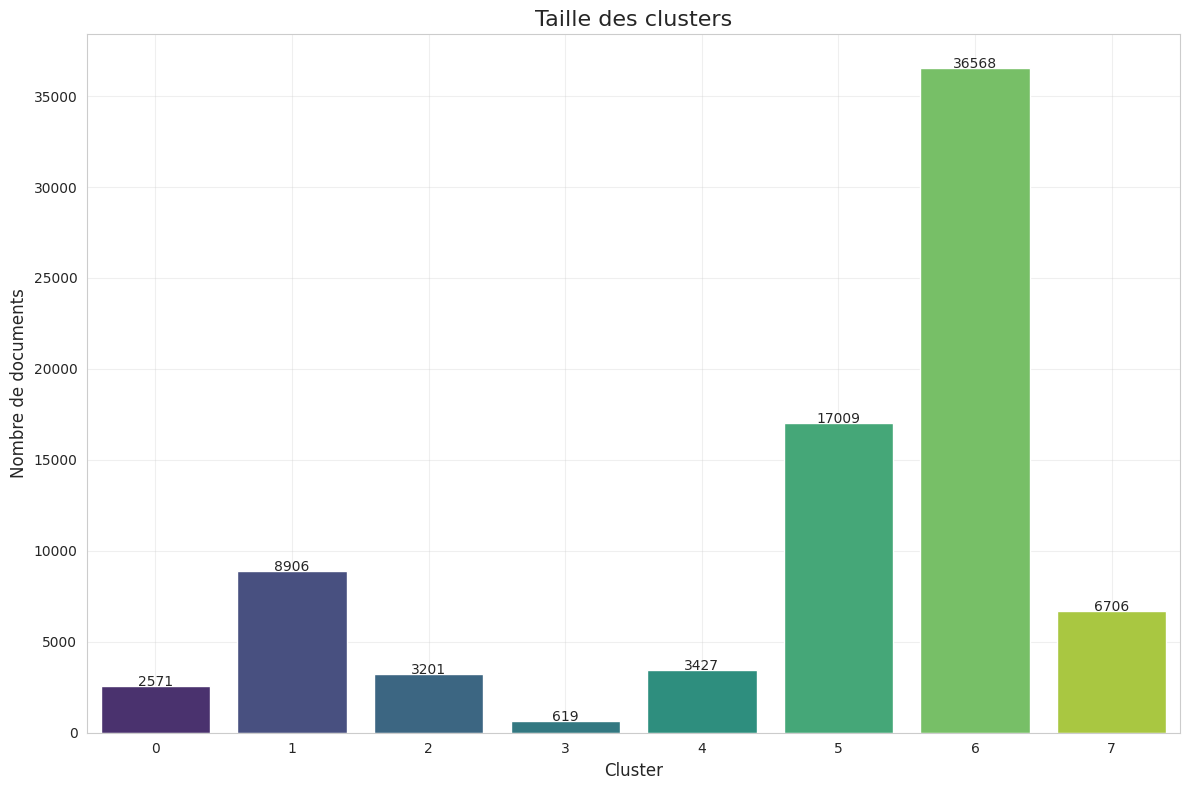

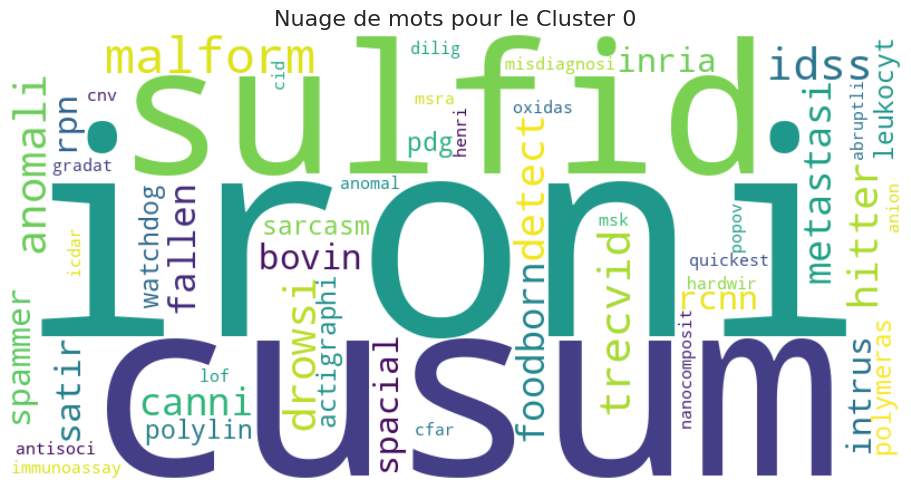

<Figure size 640x480 with 0 Axes>

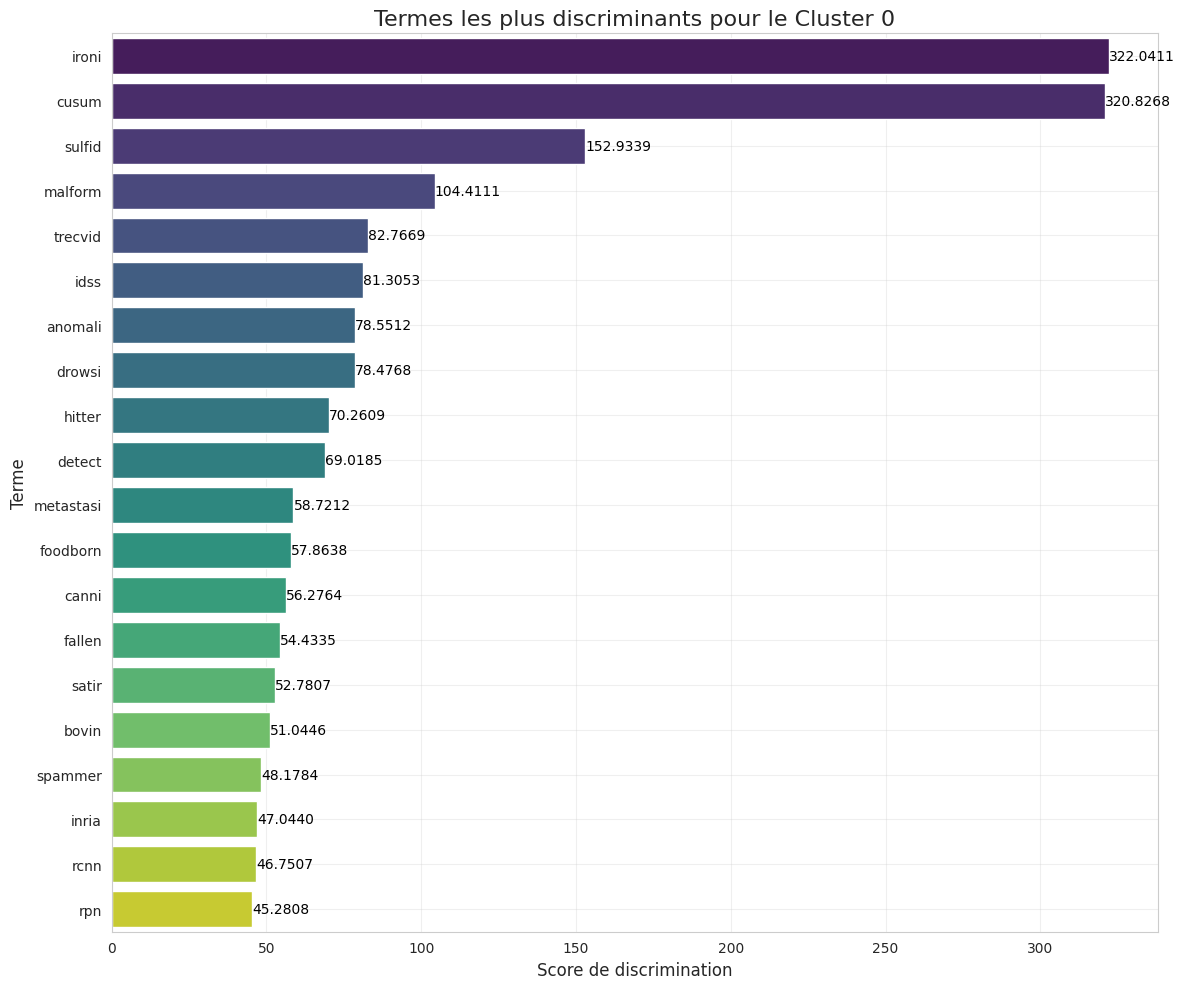

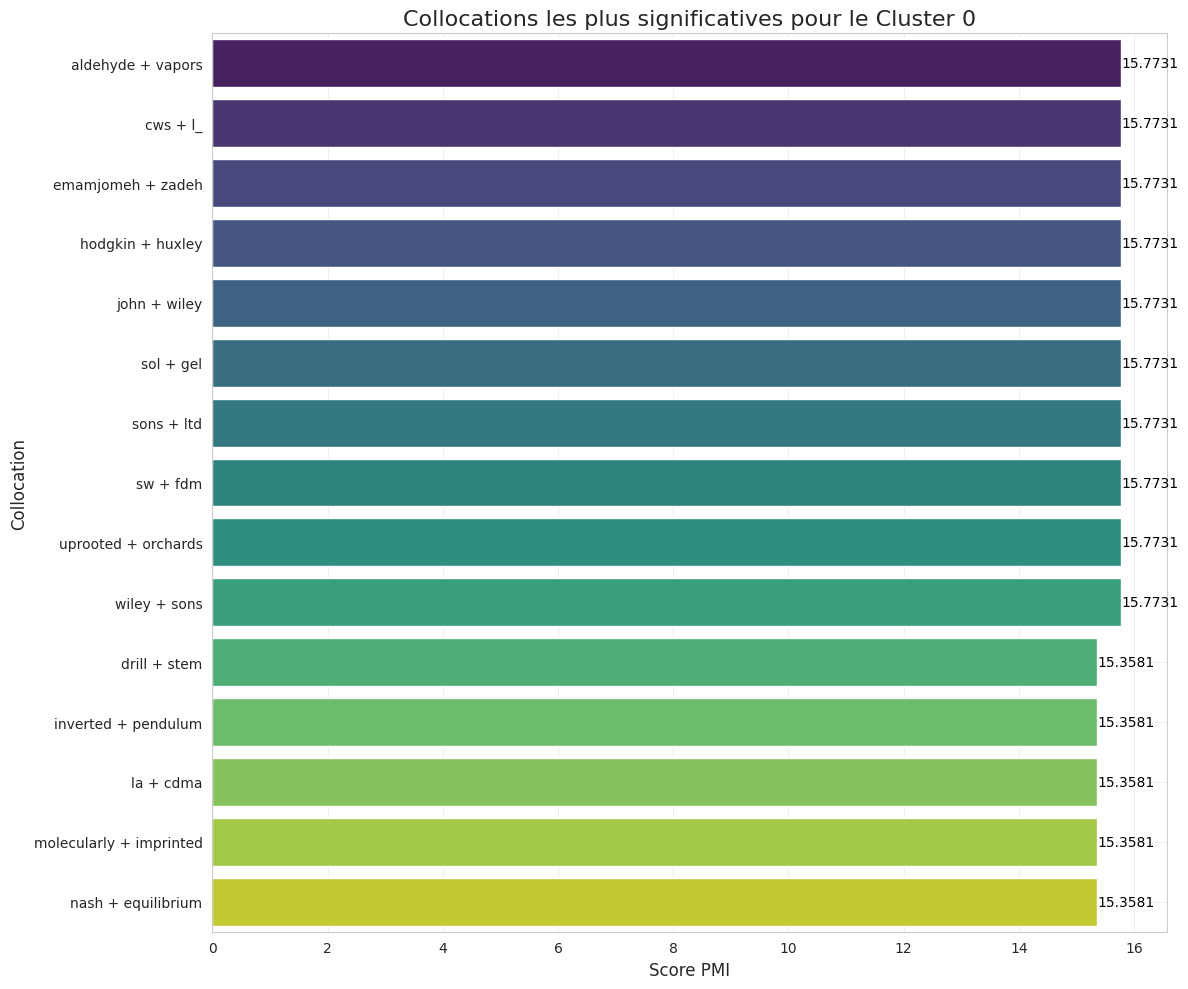

# Résumé du Cluster 0

## Informations générales
- Nombre de documents: 2571

## Termes les plus fréquents
- system: 1618
- featur: 1147
- algorithm: 1084
- perform: 1030
- network: 1028
- model: 979
- time: 902
- object: 862
- propos: 737
- attack: 713

## Termes les plus discriminants
- ironi: 322.0411
- cusum: 320.8268
- sulfid: 152.9339
- malform: 104.4111
- trecvid: 82.7669
- idss: 81.3053
- anomali: 78.5512
- drowsi: 78.4768
- hitter: 70.2609
- detect: 69.0185

## Collocations significatives
- 'aldehyde vapors': 15.7731
- 'cws l_': 15.7731
- 'emamjomeh zadeh': 15.7731
- 'hodgkin huxley': 15.7731
- 'john wiley': 15.7731

## Documents les plus représentatifs

### Document 1 (similarité: 0.3562)
- Titre: Efficient deep network for vision-based object detection in robotic applications
- Résumé: Vision-based object detection is essential for a multitude of robotic applications. However, it is also a challenging job due to the diversity of the environments in which such applications ar

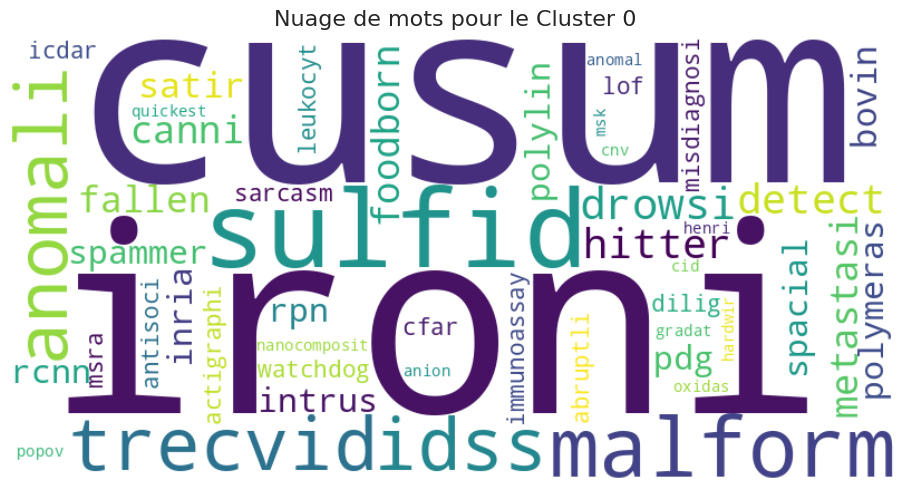

Création du nuage de mots pour le cluster 1...


<Figure size 640x480 with 0 Axes>

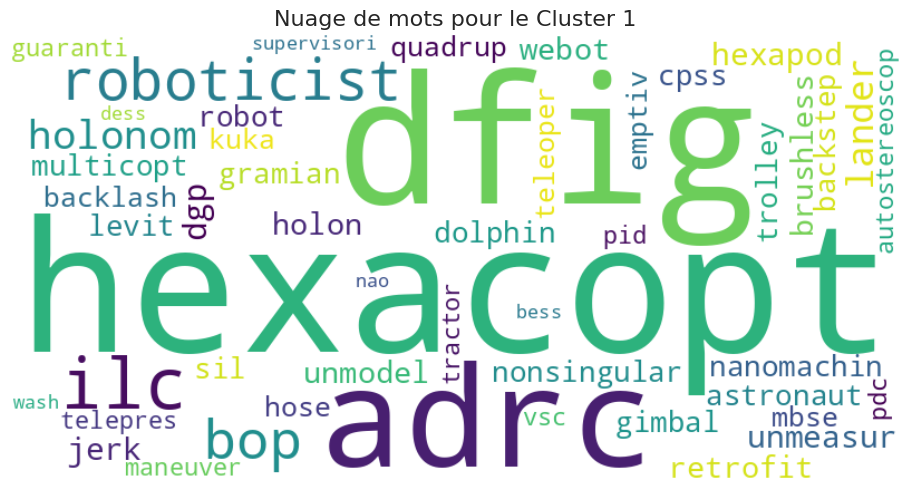

Création du nuage de mots pour le cluster 2...


<Figure size 640x480 with 0 Axes>

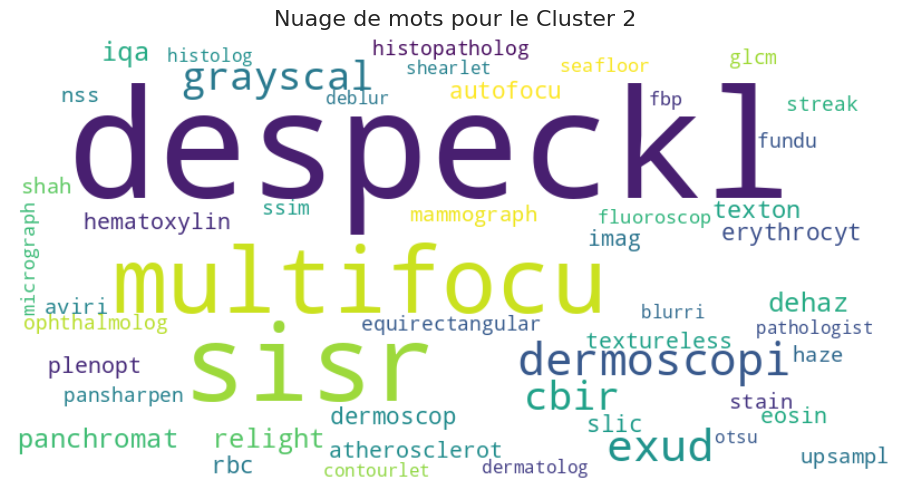

Création du nuage de mots pour le cluster 3...


<Figure size 640x480 with 0 Axes>

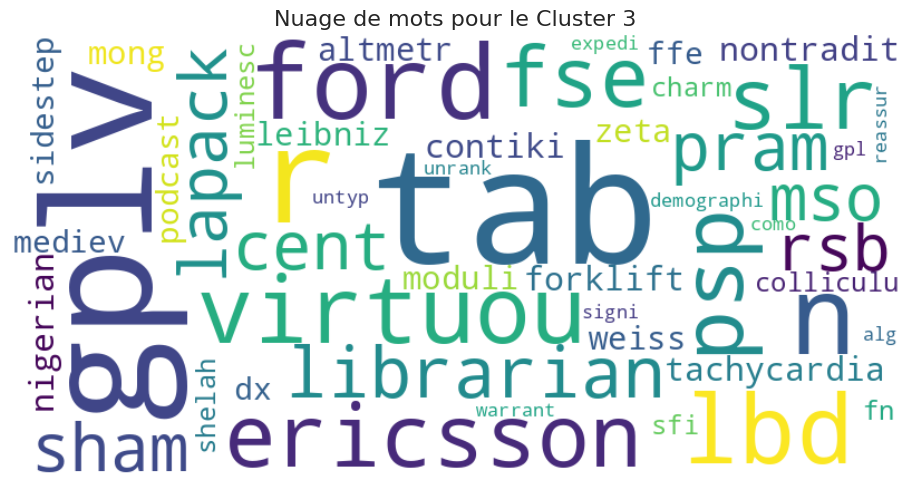

Création du nuage de mots pour le cluster 4...


<Figure size 640x480 with 0 Axes>

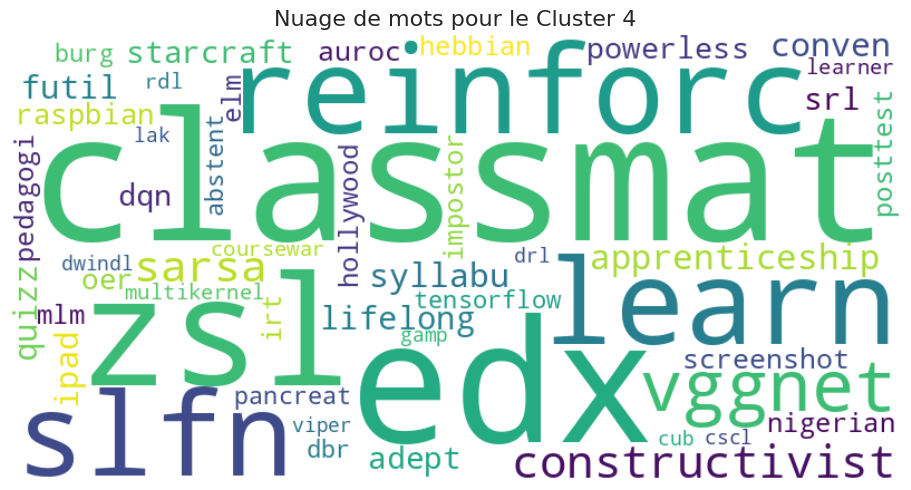

Création du nuage de mots pour le cluster 5...


<Figure size 640x480 with 0 Axes>

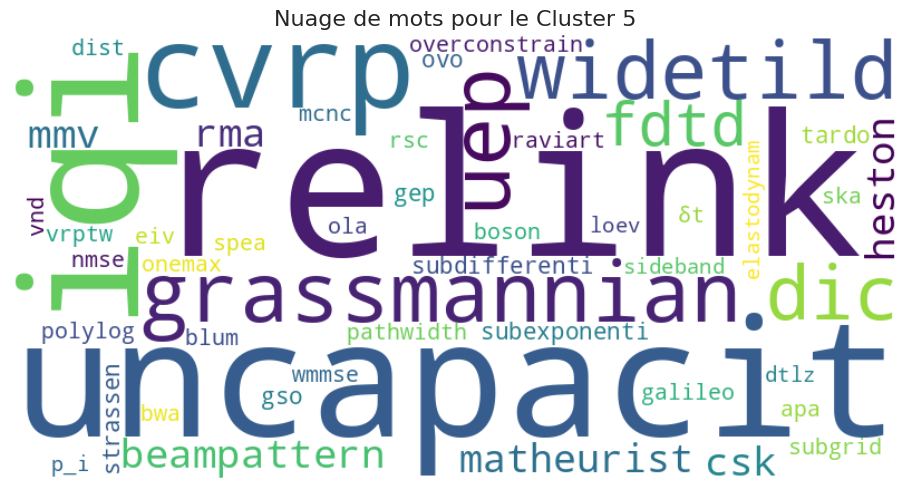

Création du nuage de mots pour le cluster 6...


<Figure size 640x480 with 0 Axes>

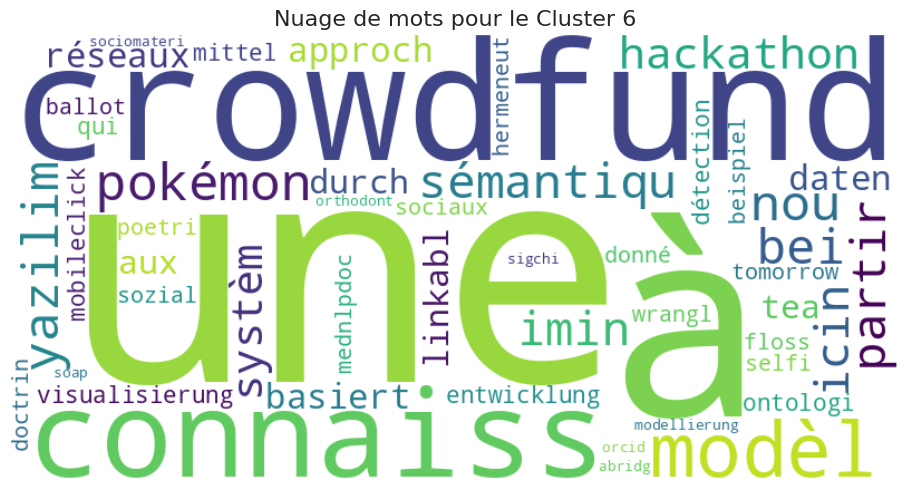

Création du nuage de mots pour le cluster 7...


<Figure size 640x480 with 0 Axes>

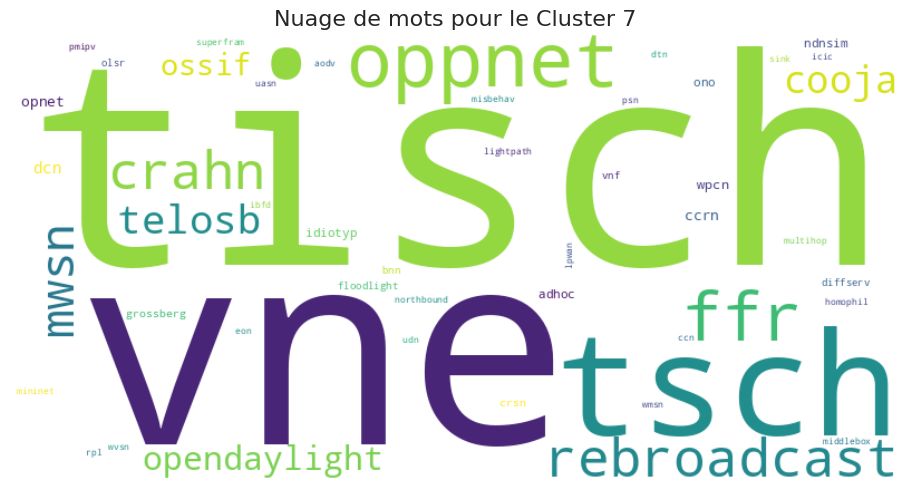

Nuages de mots enregistrés dans le répertoire 'cluster_wordclouds'
Rapport de synthèse enregistré dans 'cluster_summary.md'


'cluster_summary.md'

<Figure size 640x480 with 0 Axes>

In [14]:
# 10. Visualisations
visualizer = CategoryVisualizer(labeler)

# Taille des clusters
visualizer.plot_cluster_sizes()

# Choisir un cluster pour les visualisations
cluster_id = list(labeler.clusters)[0]  # Premier cluster

# Nuage de mots
visualizer.create_term_wordcloud(cluster_id, use_discriminative=True)

# Termes discriminants
visualizer.plot_discriminative_terms(cluster_id, n_terms=20)

# Collocations
visualizer.plot_collocation_graph(cluster_id, n_collocations=15)

# Création du rapport de synthèse pour un cluster
print(labeler.generate_cluster_summary(cluster_id))

# Création de tous les nuages de mots
visualizer.create_all_wordclouds(output_dir='cluster_wordclouds', use_discriminative=True)

# Création du rapport complet
visualizer.create_cluster_summary_report(output_file='cluster_summary.md')